# Batch Active Learning

While it is possible to perform rudimentary data selection simply by randomly choosing samples, the batch of data thus drawn might not be the most informative one.
Choosing those samples with the largest prediction uncertainties from trajectories often results in the selection of configurations from subsequent time steps.

Batch selection methods can be constructed to select informative and diverse data, with or without following the underlying distribution.

We will illustrate this in a mock learning on the fly setup.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import yaml
from ase import units
from ase.io import read
from ase.io.trajectory import TrajectoryWriter
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.optimize.fire import FIRE

from apax.bal import api
from apax.md import ASECalculator
from apax.utils.datasets import download_md22_benzene_CCSDT, mod_md_datasets
from apax.utils.helpers import mod_config

E0000 00:00:1732193422.542165  479577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732193422.545349  479577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Acquisition

In [2]:
# Download CCSD(T) Data
data_path = Path("project")
cc_train_file_path, cc_val_file_path = download_md22_benzene_CCSDT(data_path)
cc_train_file_path = mod_md_datasets(cc_train_file_path)
cc_val_file_path = mod_md_datasets(cc_val_file_path)

## Model Training

Unlike simpler data selection methods, such as random selection, we first need to train a model.
It is the representation learned by the model which will serve as the basis for our similarity metric.

In [3]:
!apax template train --full

In [4]:
config_path = Path("config_full.yaml")

config_updates = {
    "n_epochs": 200,
    "data": {
        "batch_size": 4,
        "valid_batch_size": 100,
        "experiment": "benzene",
        "directory": "project/models",
        "train_data_path": str(cc_train_file_path),
        "val_data_path": str(cc_val_file_path),
        "data_path": None,
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
}
config_dict = mod_config(config_path, config_updates)

with open("config_full.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

In [5]:
!apax train config_full.yaml

E0000 00:00:1732193427.067501  479680 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732193427.070561  479680 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO | 12:50:28 | Running on [CudaDevice(id=0)]
INFO | 12:50:28 | Initializing Callbacks
INFO | 12:50:28 | Initializing Loss Function
INFO | 12:50:28 | Initializing Metrics
INFO | 12:50:28 | Running Input Pipeline
INFO | 12:50:28 | Reading training data file project/benzene_ccsd_t-train_mod.xyz
INFO | 12:50:28 | Reading validation data file project/benzene_ccsd_t-test_mod.xyz
INFO | 12:50:29 | Found n_train: 1000, n_val: 500
INFO | 12:50:29 | Computing per element energy regression.
INFO | 12:50:30 | Building Standard model
INFO | 12:50:30 | initializing 1 model(s)
INFO | 12:50:36 | Initializing Optimizer
INFO | 12:50:36 | Beginning Traini

## Molecular Dynamics / Data Generation

Now we will create a pool of data to select new samples from.
In order to emphasize the selection method used in the next section, we will combine MD and geometry optimization, a common occurrence in learning on the fly.

In [6]:
atoms = read(str(cc_train_file_path), "0")
calc = ASECalculator("project/models/benzene")
atoms.calc = calc

In [7]:
def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(
        "Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  "
        "Etot = %.3feV" % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin)
    )


writer = TrajectoryWriter("project/benzene.traj", "w", atoms)

MaxwellBoltzmannDistribution(atoms, temperature_K=298)
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=298, friction=0.002)
dyn.attach(writer, interval=100)
dyn.attach(printenergy, interval=1000)
dyn.run(10000)

opt = FIRE(atoms)
opt.attach(writer)
opt.run()

Energy per atom: Epot = -524.782eV  Ekin = 0.045eV (T=345K)  Etot = -524.738eV
Energy per atom: Epot = -524.786eV  Ekin = 0.038eV (T=298K)  Etot = -524.747eV
Energy per atom: Epot = -524.791eV  Ekin = 0.044eV (T=339K)  Etot = -524.748eV
Energy per atom: Epot = -524.797eV  Ekin = 0.054eV (T=415K)  Etot = -524.743eV
Energy per atom: Epot = -524.783eV  Ekin = 0.038eV (T=297K)  Etot = -524.745eV
Energy per atom: Epot = -524.787eV  Ekin = 0.033eV (T=259K)  Etot = -524.754eV
Energy per atom: Epot = -524.777eV  Ekin = 0.045eV (T=345K)  Etot = -524.732eV
Energy per atom: Epot = -524.785eV  Ekin = 0.055eV (T=429K)  Etot = -524.729eV
Energy per atom: Epot = -524.780eV  Ekin = 0.056eV (T=432K)  Etot = -524.724eV
Energy per atom: Epot = -524.766eV  Ekin = 0.046eV (T=355K)  Etot = -524.720eV
Energy per atom: Epot = -524.772eV  Ekin = 0.041eV (T=317K)  Etot = -524.731eV
      Step     Time          Energy          fmax
FIRE:    0 12:52:42    -6297.264360        5.423857
FIRE:    1 12:52:42    -6297.

True

## Selecting New Datapoints

Now it is time to select new data points from our pool.
In the following we choose the last-layer gradient kernel as the similarity metric and the max dist selection method (farthest point sampling) to select 10 datapoints from out pool.

In [8]:
train_atoms = read(str(cc_train_file_path), ":")
pool_atoms = read("project/benzene.traj", ":")

In [9]:
len(pool_atoms)

148

In [10]:
base_fm_options = {"name": "ll_grad", "layer_name": "dense_2"}
selection_method = "max_dist"

bs = 10

selected_indices = api.kernel_selection(
    "project/models/benzene",
    train_atoms,
    pool_atoms,
    base_fm_options,
    selection_method,
    selection_batch_size=bs,
    processing_batch_size=bs,
)

Computing features: 100%|██████████████████████████████████████| 1148/1148 [00:02<00:00, 434.57it/s]


In [11]:
selected_indices

(array([127,  85,  73,  82,  19,  95,  26,  30,   4,   5]),
 array([1.2732200e+05, 3.1276562e+02, 9.2281250e+01, 6.8921875e+01,
        2.7906250e+01, 2.3593750e+01, 2.3109375e+01, 1.4125000e+01,
        1.1515625e+01, 1.0906250e+01], dtype=float32),
 array([[-1.02811443e-16, -1.15199308e-08, -6.91606624e-12, ...,
         -3.46590080e-16, -1.09975839e-11,  7.53225851e+00],
        [-8.95747069e-17, -1.12410099e-08, -1.78736073e-12, ...,
         -2.70460796e-16, -9.23120261e-12,  7.53225851e+00],
        [-1.09106625e-16, -1.10739000e-08, -1.27026905e-12, ...,
         -3.80384603e-16, -1.05209400e-11,  7.53225851e+00],
        ...,
        [-9.81537147e-17, -1.13610081e-08, -1.53432952e-12, ...,
         -3.13202873e-16, -9.99714547e-12,  7.53225851e+00],
        [-1.01867855e-16, -1.11062928e-08, -2.01783685e-12, ...,
         -3.15307803e-16, -1.00044122e-11,  7.53225851e+00],
        [-1.05319388e-16, -1.19797869e-08, -1.89715279e-12, ...,
         -3.41599361e-16, -1.05473148e-11

In [12]:
energies = np.array([a.get_potential_energy() for a in pool_atoms])
# selected_indices = np.random.randint(0, len(energies), 10)
selection_energies = energies[selected_indices[0]]

As we can see below, the batch selection method only picks a few data points from the optimization part of the pool, indicating that during an optimization the structure of the molecule does not change very much.
Hence, there are not many informative samples to be found in it.

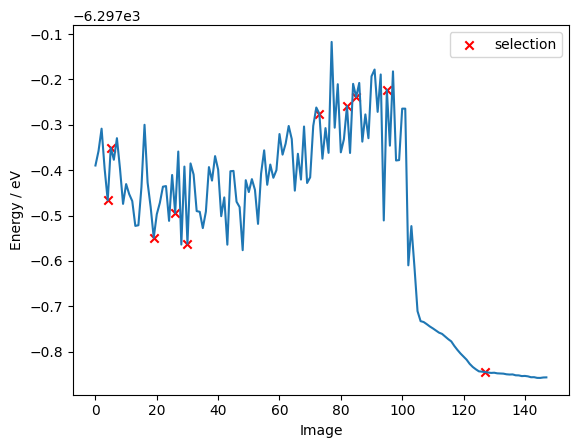

In [13]:
fig, ax = plt.subplots()

ax.plot(energies)
ax.scatter(
    selected_indices[0], selection_energies, marker="x", color="red", label="selection"
)
ax.set_ylabel("Energy / eV")
ax.set_xlabel("Image")
ax.legend()

In [1]:
!rm -rf project config_full.yaml